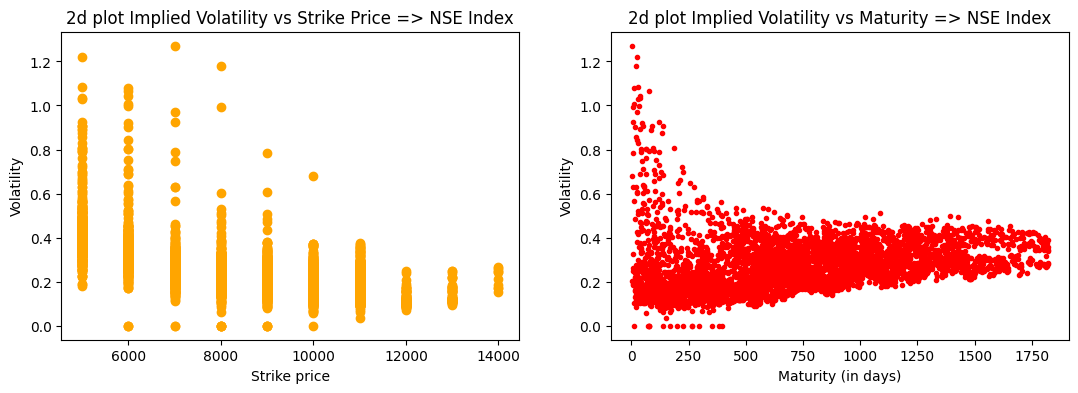

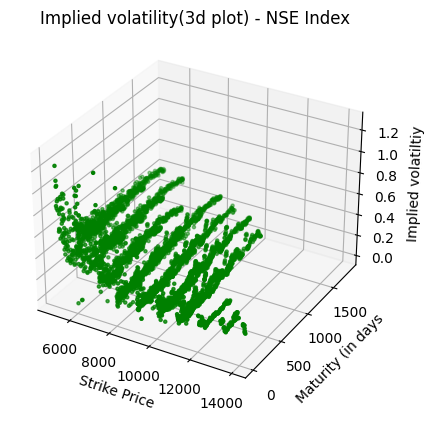

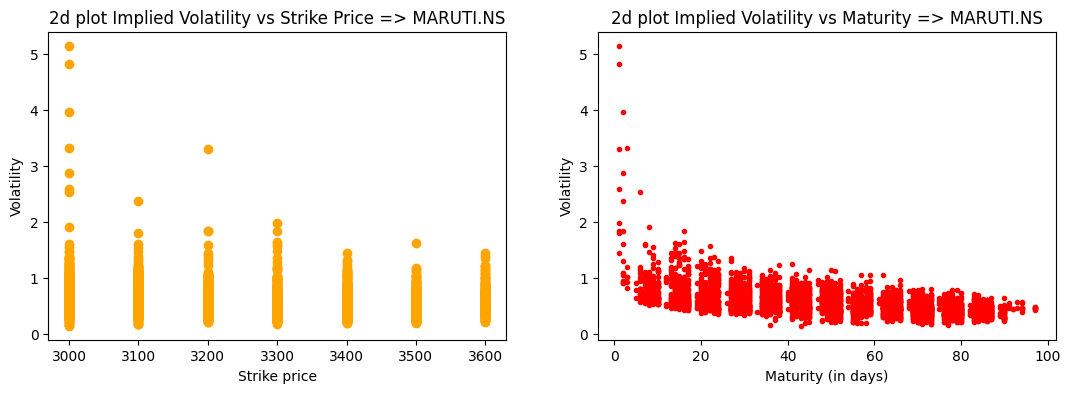

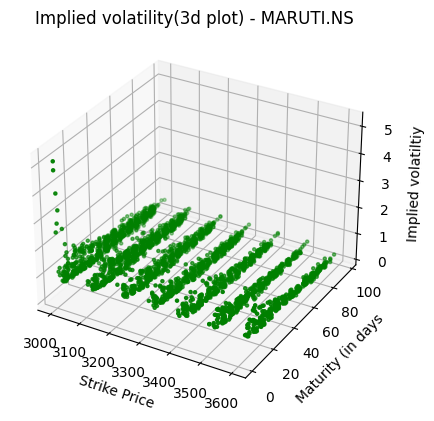

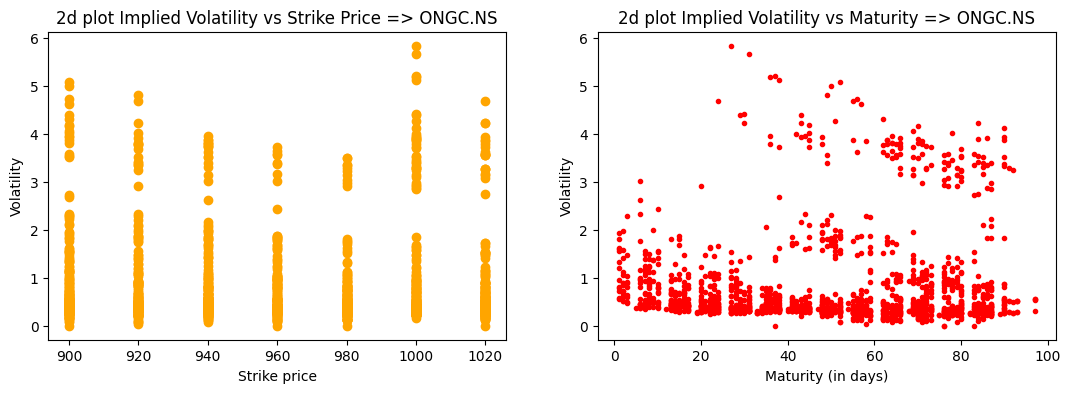

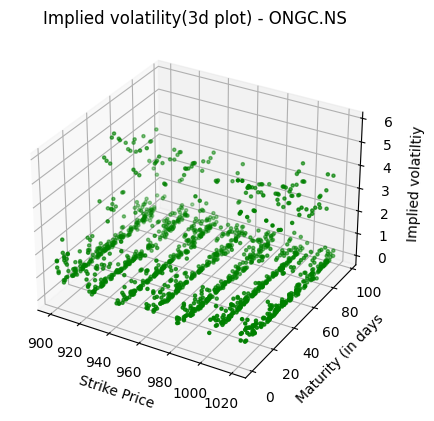

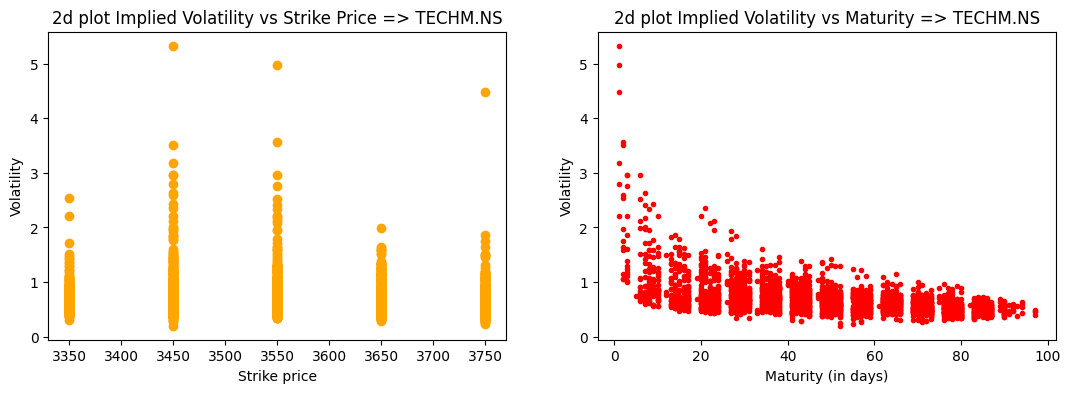

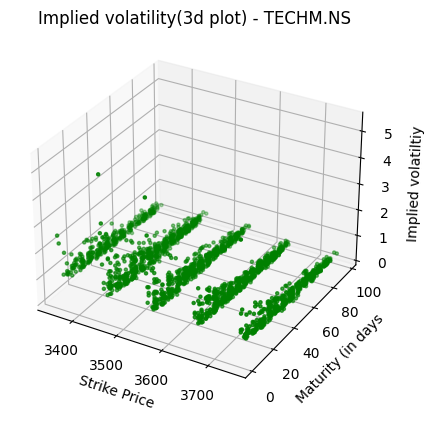

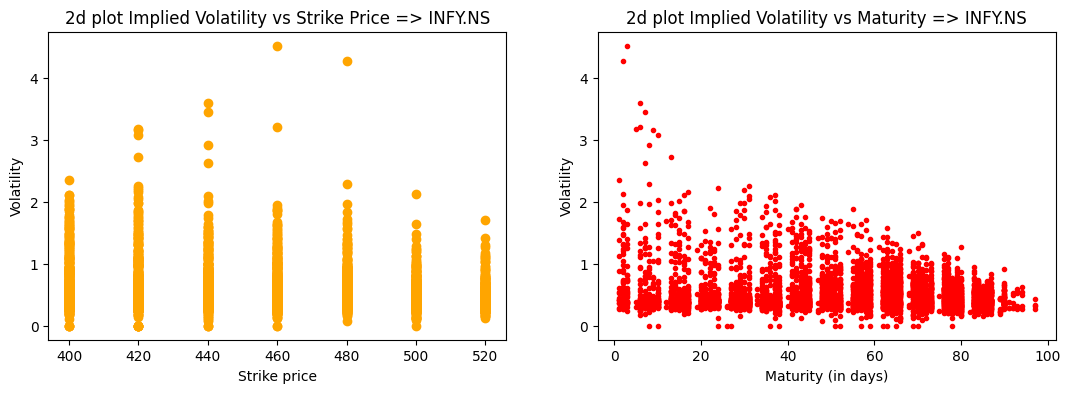

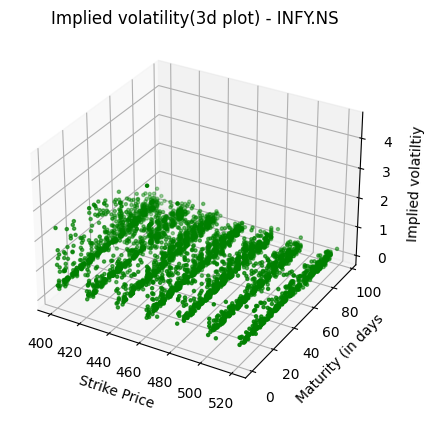

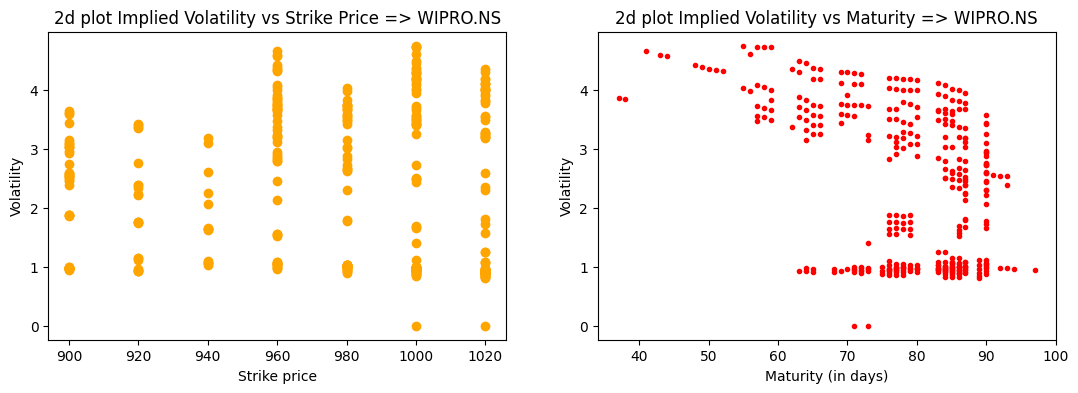

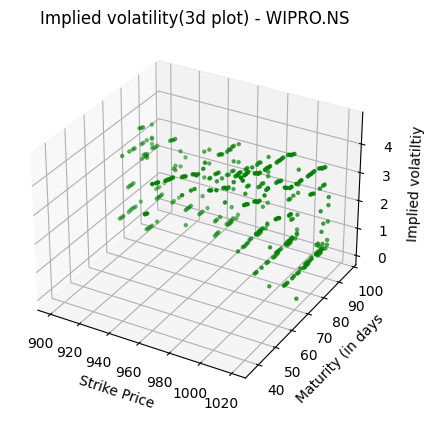

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from datetime import datetime
from scipy.misc import derivative
from scipy.stats import norm

# if using a Jupyter notebook, kindly uncomment the following line:
# %matplotlib inline


def fx(C, x, K, t, T, r, sigma):
    if t == T:
        return max(0, x - K), max(0, K - x)

    d1 = ( math.log(x/K) + (r + 0.5 * sigma * sigma) * (T - t) ) / ( sigma * math.sqrt(T - t) )
    d2 = ( math.log(x/K) + (r - 0.5 * sigma * sigma) * (T - t) ) / ( sigma * math.sqrt(T - t) )

    call_price = x * norm.cdf(d1) - K * math.exp( -r * (T - t) ) * norm.cdf(d2)
    return C - call_price


def dfx(fx, var=0, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return fx(*args)

    return derivative(wraps, point[var], dx = 1e-4)
  

def newton_method(epsilon, C, x, K, t, T, r, x0):
    itnum = 1
    root = 0

    while itnum <= 1000:
        denom = dfx(fx, 6, [C, x, K, t, T, r, x0])
        if denom == 0:
            return -1

        x1 = x0 - fx(C, x, K, t, T, r, x0)/denom
        if abs(x1 - x0) <= epsilon:
            root = x1
            break

        x0 = x1
        itnum += 1

    return root


def plot(filename, opt_type):
    plt.rcParams["figure.figsize"] = (13, 4)
    df = pd.read_csv(filename)
    df = df.interpolate(method='linear', axis=0).ffill().bfill()

    strike_price, maturity, volatility = [], [], []
    for index, row in df.iterrows():
        num = random.random()
        bound = 0.25
        if opt_type == 'WIPRO.NS':
            bound = 1

        if num <= bound:
            d1 = datetime.strptime(row['Expiry'],  '%d-%b-%y')
            d2 = datetime.strptime(row['Date'],  '%d-%m-%Y')
            delta = d1 - d2
            if int(row['Call Price']) != 0 and delta.days != 0:
                sigma = newton_method(1e-6, row['Call Price'], row['Stock Price'], row['Strike Price'], 0, delta.days/365, 0.05, 0.6)
                
                if sigma != -1:
                    strike_price.append(row['Strike Price'])
                    volatility.append(sigma)
                    maturity.append(delta.days)
    
    plt.subplot(1, 2, 1)
    plt.scatter(strike_price, volatility, marker = 'o',color='orange')
    plt.xlabel('Strike price')
    plt.ylabel('Volatility')
    plt.title('2d plot Implied Volatility vs Strike Price => {}'.format(opt_type))
    
    plt.subplot(1, 2, 2)
    plt.scatter(maturity, volatility, marker = '.',color='red')
    plt.xlabel('Maturity (in days)')
    plt.ylabel('Volatility')
    plt.title('2d plot Implied Volatility vs Maturity => {}'.format(opt_type))
    plt.show()

    mpl.rcParams.update(mpl.rcParamsDefault)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(strike_price, maturity, volatility, marker = '.',color='green')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Maturity (in days')
    ax.set_zlabel('Implied volatiltiy')
    ax.set_title('Implied volatility(3d plot) - {}'.format(opt_type))
    plt.show()


def main():
    files = ['NIFTYoptiondata', 'stockoptiondata_MARUTI', 'stockoptiondata_ONGC', 'stockoptiondata_TECHM', 'stockoptiondata_INFY', 'stockoptiondata_WIPRO']
    opt_type = ['NSE Index', 'MARUTI.NS', 'ONGC.NS', 'TECHM.NS', 'INFY.NS', 'WIPRO.NS']

    for idx in range(len(files)):
        files[idx] = './' + files[idx] + '.csv'
        plot(files[idx], opt_type[idx])


if __name__=="__main__":
  main()